# OONI Data Analysis

In [2]:
# Basic Imports
import pandas as pd
import numpy as np
import os
from urllib.parse import urlparse

# Plotting Imports
from matplotlib import pyplot as plt
import seaborn as sns

# sklearn
from sklearn import metrics

# Statstools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [3]:
# Plot configuration
sns.set_style('darkgrid')
sns.set_palette('tab10')
palette = sns.color_palette()

In [7]:
# Data paths
base_dir = '../../../Data/'
hr_dir = os.path.join(base_dir, 'HR', 'processed')
hr_years = ['2021', '2022', '2023']
np_dir = os.path.join(base_dir, 'NP', 'processed')
np_years = ['2022']
by_dir = os.path.join(base_dir, 'BY', 'processed')
by_years = ['2022']

## 1 Introduction

(INTRODUCTION)

### 1.1 Dataset

*You must provide background on the dataset or datasets you
worked with, such as who created it, why, how it was collected, for what purpose
it was collected, what attributes are included, what representation decisions
were made and how that affects the data, etc. A good reference for questions
to ask about your data is the paper “Datasheets for Datasets,” by Gebru et al.
(2018) (https://arxiv.org/abs/1803.09010).*

We focused on the web connectivity test particularly due to the large volume of data that was collected.  This test checks whether specific sites are reachable by the client, and if it is actually unreachable, which type of blocking mechanism could be the potential cause.

In [27]:
# Load all datasets
web_data = {
    'hr' : {
        year : pd.read_csv(os.path.join(hr_dir, year, 'webconnectivity.csv')) for year in hr_years
    },
    'np' : {
        year : pd.read_csv(os.path.join(np_dir, year, 'webconnectivity.csv')) for year in np_years
    },
    'by' : {
        year : pd.read_csv(os.path.join(by_dir, year, 'webconnectivity.csv')) for year in by_years
    }
}

# Standardize URLs
def url_standardize(url):
    p = urlparse(url)
    b = p.netloc.split('.')
    c = '.'.join(b[len(b)-2:])  # Remove any www
    return c+p.path

# Loop through all datasets and clean
for country in web_data:
    for year in web_data[country]:
        wd = web_data[country][year]
        wd['date'] = pd.to_datetime(wd['date'])
        wd = wd.set_index('date')
        wd['input'] = wd['input'].map(url_standardize)
        web_data[country][year] = wd

Example data (Nepal 2022):

In [90]:
# Show some example data
web_data['np']['2022']

,probe_asn,http_experiment_failure,x_dns_flags,status_code_match,resolver_asn,headers_match,blocking,body_length_match,input,control_failure,title_match,accessible,x_null_null_flags,x_blocking_flags,body_proportion,dns_consistency,dns_experiment_failure
date,,,,,,,,,,,,,,,,,
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,fteproxy.org/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,sbc.net/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,ecequality.org/,NaN,True,True,NaN,NaN,1.000000,inconsistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,episcopalchurch.org/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,icrw.org/,NaN,True,True,NaN,NaN,0.999723,consistent,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS23752,NaN,NaN,True,AS23752,True,False,True,facebook.com/,NaN,NaN,True,NaN,NaN,0.975015,consistent,NaN
2022-12-31,AS23752,NaN,NaN,False,AS23752,True,False,NaN,instagram.com/,NaN,NaN,True,NaN,NaN,0.000000,consistent,NaN
2022-12-31,AS23752,NaN,NaN,True,AS23752,True,False,NaN,youtube.com/,NaN,NaN,True,NaN,NaN,0.000000,consistent,NaN


There are several blocking modalities which we can observe in the `blocking` column of the dataset:

In [31]:
# Show unique test types
event_types = pd.Series(web_data['hr']['2022']['blocking'].dropna().sort_values().unique())
event_types

0           False
1             dns
2       http-diff
3    http-failure
4          tcp_ip
dtype: object

These specific blocking test types are:
* `dns` - The DNS server does not resolve the site properly
  * This is used commonly to (TODO)
* `httpdiff` - The page accessed is not the page the original page
  * This is commonly a "blocked" page displayed instead of the real page
* `httpfail` - The http fails explicitly
* `tcp` - TCP connection has failed
* `False` - No blocking methods were detected

In [41]:
# Filter data into specific blocking methods
blocking_events = {
    country : {
        year : {
            event_type: web_data[country][year][web_data[country][year]['blocking'] == event_type]
            for event_type in event_types
        } for year in web_data[country]
    } for country in web_data
}

In [48]:
# Compute rolling totals
k=7
totals = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
for country in blocking_events:
    for year in blocking_events[country]:
        for event_type in blocking_events[country][year]:
            # Calculate date range
            date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')

            # Fill all empty events with zeroes
            d = blocking_events[country][year][event_type]
            tmp = d.groupby(d.index).size()
            totals[country][year][event_type] = tmp.reindex(date_range, fill_value=0).rolling(window=k).sum().dropna()

In [62]:
# Calculate fractional events
fracs = {country : { year : {} for year in totals[country] } for country in totals}
for country in totals:
    for year in totals[country]:
        # Calculate fractional of all possible events
        d = pd.DataFrame(totals[country][year])
        tsum = d.sum(axis=1)
        fracs[country][year] =  d.div(tsum, axis=0).fillna(0)

Let's take a look at what types of events are occurring throughout time in various countries.

Text(0.5, 1.0, 'Fractional Blocking Events For Nepal in 2022 Over Time (k=7)')

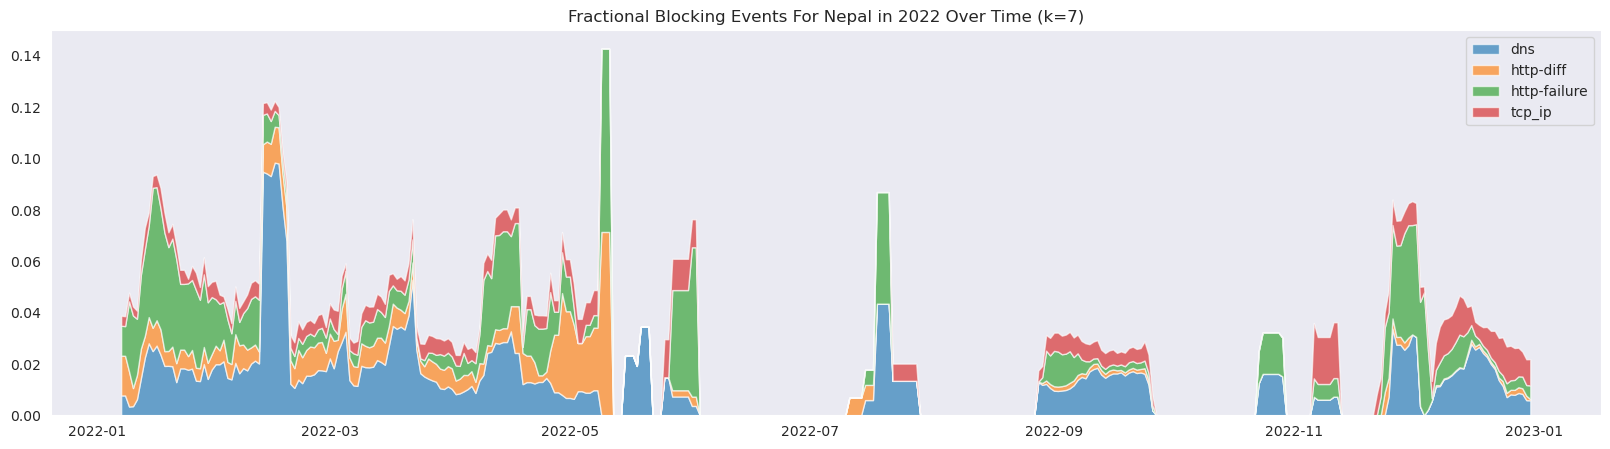

In [87]:
# Select a country and year
country = 'np'
year = '2022'
f = fracs[country][year]
f = f[f.columns[f.columns != 'False']]
ft = [f[c] for c in f.columns.sort_values()]

# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(ft[0].index, *ft, labels=f.columns.sort_values(), alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events For Nepal in {year} Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events For Belarus in 2022 Over Time (k=7)')

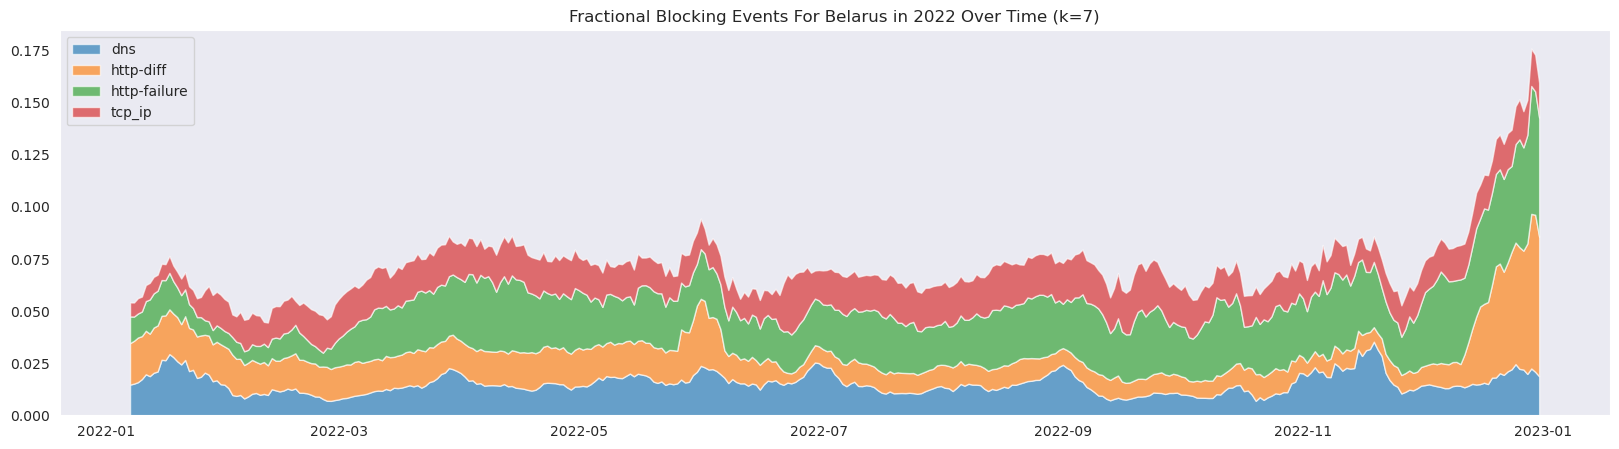

In [89]:
# Select a country and year
country = 'by'
year = '2022'
f = fracs[country][year]
f = f[f.columns[f.columns != 'False']]
ft = [f[c] for c in f.columns.sort_values()]

# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(ft[0].index, *ft, labels=f.columns.sort_values(), alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events For Belarus in {year} Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events For Croatia in 2022 Over Time (k=7)')

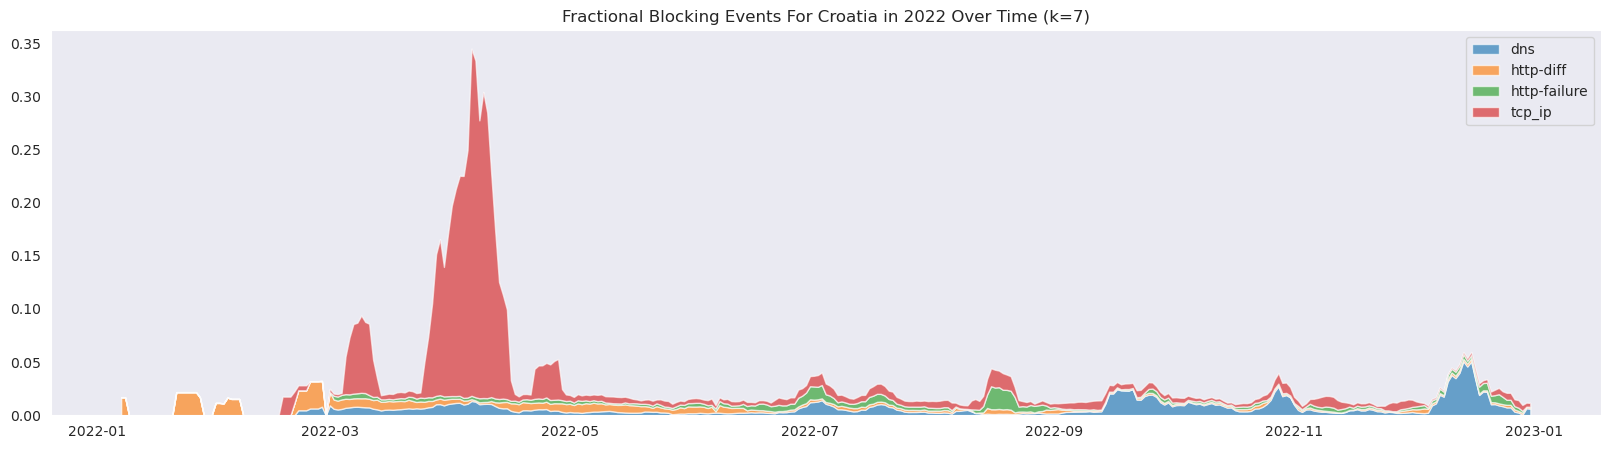

In [86]:
# Select a country and year
country = 'hr'
year = '2022'
f = fracs[country][year]
f = f[f.columns[f.columns != 'False']]
ft = [f[c] for c in f.columns.sort_values()]

# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(ft[0].index, *ft, labels=f.columns.sort_values(), alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events For Croatia in {year} Over Time (k={k})')

Looking at these three plots, 

----

## Questions

*You must clearly state the questions you’re attempting to answer.
Some questions could be a bit vague or broad, such as determining the basic
properties of the different attributes, but others should be more specific, such
as determining if a particular relationship exists.*